

# Explore event-related dynamics for specific frequency bands

The objective is to show you how to explore spectrally localized
effects. For this purpose we adapt the method described in
:footcite:`HariSalmelin1997` and use it on the somato dataset.
The idea is to track the band-limited temporal evolution
of spatial patterns by using the :term:`global field power` (GFP).

We first bandpass filter the signals and then apply a Hilbert transform. To
reveal oscillatory activity the evoked response is then subtracted from every
single trial. Finally, we rectify the signals prior to averaging across trials
by taking the magnitude of the Hilbert.
Then the :term:`GFP` is computed as described in
:footcite:`EngemannGramfort2015`, using the sum of the
squares but without normalization by the rank.
Baselining is subsequently applied to make the :term:`GFP` comparable
between frequencies.
The procedure is then repeated for each frequency band of interest and
all :term:`GFPs<GFP>` are visualized. To estimate uncertainty, non-parametric
confidence intervals are computed as described in :footcite:`EfronHastie2016`
across channels.

The advantage of this method over summarizing the Space × Time × Frequency
output of a Morlet Wavelet in frequency bands is relative speed and, more
importantly, the clear-cut comparability of the spectral decomposition (the
same type of filter is used across all bands).

We will use this dataset: `somato-dataset`

## References
.. footbibliography::


In [ ]:
# Authors: Denis A. Engemann <denis.engemann@gmail.com>
#          Stefan Appelhoff <stefan.appelhoff@mailbox.org>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

Set parameters



In [3]:
# data_path = somato.data_path()
subject = "01"
task = "somato"
raw_fname = "fif/20240425-135521-Epoc X-raw.fif copy"

# let's explore some frequency bands
iter_freqs = [("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 25), ("Gamma", 30, 45)]

In [4]:
mne.Epochs.drop_log_stats(epochs)

NameError: name 'epochs' is not defined

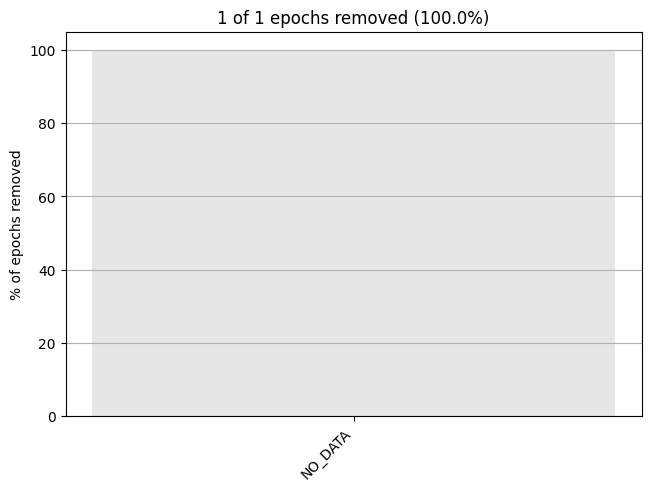

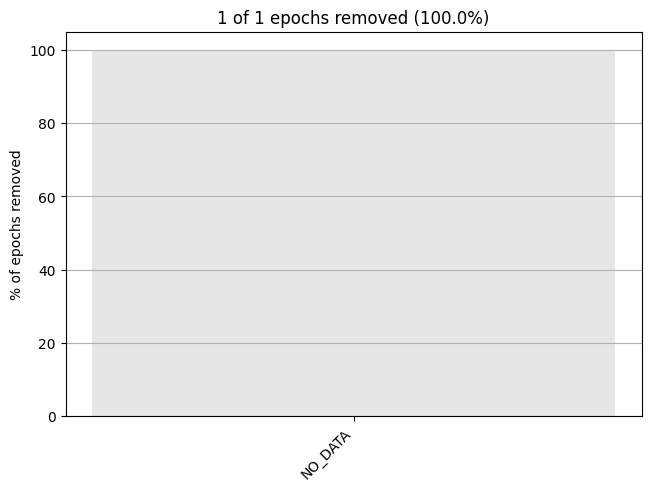

In [52]:
mne.Epochs.plot_drop_log(epochs)

We create average power time courses for each frequency band



In [5]:
# set epoching parameters

event_id, tmin, tmax = 1, -1.0, 3.0
baseline = None

# get the header to extract events
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.add_events(np.array([10, 0, 1]).reshape(1, 3), "F7")
events = mne.find_events(raw, stim_channel="F7")

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_fif(raw_fname)
    raw.pick(picks=["eeg"])  # we just look at gradiometers
    raw.load_data()

    # bandpass filter
    raw.filter(
        fmin,
        fmax,
        n_jobs=None,  # use more jobs to speed up.
        l_trans_bandwidth=1,  # make sure filter params are the same
        h_trans_bandwidth=1,
    )  # in each band and skip "auto" option.

    # epoch
    # epochs = mne.Epochs(
    #     raw,
    #     events,
    #     event_id,
    #     tmin,
    #     tmax,
    #     baseline=baseline,
    #     picks=['eeg'],
    #     # reject=dict(eeg=350e-6),
    #     preload=True,
    # )
    # # remove evoked response
    # epochs.subtract_evoked()
    

    # get analytic signal (envelope)
    # epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), raw))
    # del epochs

Opening raw data file fif/20240425-135521-Epoc X-raw.fif copy...
Isotrak not found
    Range : 0 ... 2874 =      0.000 ...    11.227 secs
Ready.
Reading 0 ... 2874  =      0.000 ...    11.227 secs...
1 event found on stim channel F7
Event IDs: [1]
Opening raw data file fif/20240425-135521-Epoc X-raw.fif copy...
Isotrak not found
    Range : 0 ... 2874 =      0.000 ...    11.227 secs
Ready.
Reading 0 ... 2874  =      0.000 ...    11.227 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 845 samples (3.301

/var/folders/dc/f86yv5bn09b4gh091v8y99jh0000gn/T/ipykernel_63872/539586352.py:7: RuntimeWarning: This filename (fif/20240425-135521-Epoc X-raw.fif copy) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_fname, preload=True)
/var/folders/dc/f86yv5bn09b4gh091v8y99jh0000gn/T/ipykernel_63872/539586352.py:15: RuntimeWarning: This filename (fif/20240425-135521-Epoc X-raw.fif copy) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_fname)
/var/folders/dc/f86yv5bn09b4gh091v8y99jh0000gn/T/ipykernel_63872/539586352.py:15: RuntimeWarning: This filename (fif/20240425-135521-Epoc X-raw.fif

Now we can compute the Global Field Power
We can track the emergence of spatial patterns compared to baseline
for each frequency band, with a bootstrapped confidence interval.

We see dominant responses in the Alpha and Beta bands.



In [6]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,14 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,30.00 Hz
Lowpass,45.00 Hz


In [7]:
frequency_map[0][1].times.shape

(2875,)

In [8]:
frequency_map[0][1].ch_names

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

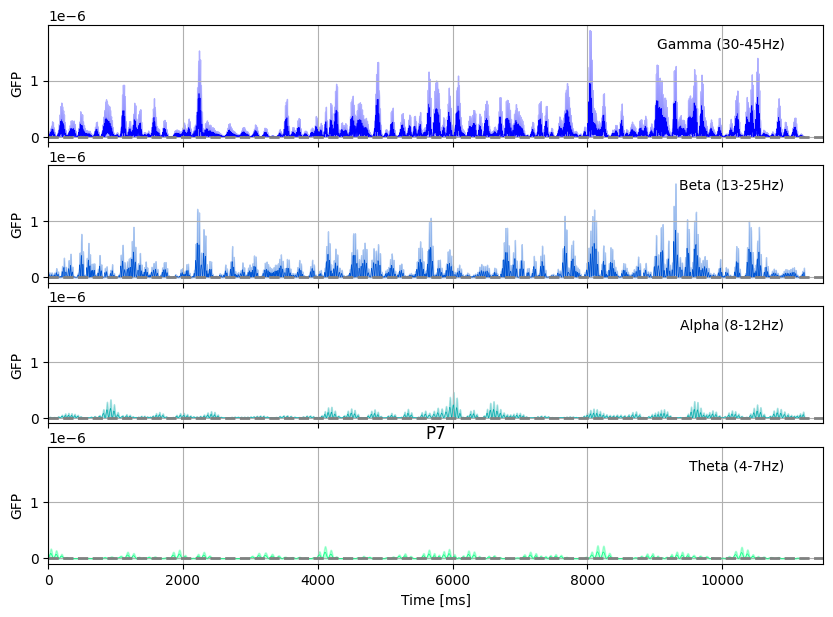

In [12]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)


# Plot
t = 2875
c = 5
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map, colors, axes.ravel()[::-1]
):
    times = average.times[:t] * 1e3
    gfp = np.sum(average.get_data()[c, :t].reshape(1, t)**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times[0], baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=0.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.get_data()[c, :t].reshape(1, t), random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(0, t*4)

plt.title(frequency_map[0][1].ch_names[c])

axes.ravel()[-1].set_xlabel("Time [ms]")